In [1]:
import math
import json

In [2]:
from kan import *
from generate_dataset import create_custom_dataset
from export_KAN import get_model_data, export_to_json
# create a KAN: 3D inputs, 1D output and 2 hidden neurons. cubic spline (k=3), 10 grid intervals
width = [2, 2, 2, 1]
model = KAN(width=width, grid=5, k=3, seed=0)

In [3]:
# Creating the functions investigated for data generation
peaks_function = lambda x: (
    3 * (1 - x[:, 0]) ** 2 * torch.exp(-x[:, 0]**2 - (x[:, 1] + 1)**2) -
    10 * (x[:, 0] / 5 - x[:, 0]**3 - x[:, 1]**5) * torch.exp(-x[:, 0]**2 - x[:, 1]**2) -
    torch.exp(-(x[:, 0] + 1)**2 - x[:, 1]**2) / 3
).unsqueeze(1)
rosenbrock_3 = lambda x: (
    100 * torch.pow(x[:, 1] - torch.pow(x[:, 0], 2), 2) + torch.pow(1 - x[:, 0], 2) +
    100 * torch.pow(x[:, 2] - torch.pow(x[:, 1], 2), 2) + torch.pow(1 - x[:, 1], 2)
).unsqueeze(1)
rosenbrock_5 = lambda x: (
    100 * torch.pow(x[:, 1] - torch.pow(x[:, 0], 2), 2) + torch.pow(1 - x[:, 0], 2) +
    100 * torch.pow(x[:, 2] - torch.pow(x[:, 1], 2), 2) + torch.pow(1 - x[:, 1], 2) +
    100 * torch.pow(x[:, 3] - torch.pow(x[:, 2], 2), 2) + torch.pow(1 - x[:, 2], 2) +
    100 * torch.pow(x[:, 4] - torch.pow(x[:, 3], 2), 2) + torch.pow(1 - x[:, 3], 2)
).unsqueeze(1)
rosenbrock_10 = lambda x: (
    100 * torch.pow(x[:, 1] - torch.pow(x[:, 0], 2), 2) + torch.pow(1 - x[:, 0], 2) +
    100 * torch.pow(x[:, 2] - torch.pow(x[:, 1], 2), 2) + torch.pow(1 - x[:, 1], 2) +
    100 * torch.pow(x[:, 3] - torch.pow(x[:, 2], 2), 2) + torch.pow(1 - x[:, 2], 2) +
    100 * torch.pow(x[:, 4] - torch.pow(x[:, 3], 2), 2) + torch.pow(1 - x[:, 3], 2) +
    100 * torch.pow(x[:, 5] - torch.pow(x[:, 4], 2), 2) + torch.pow(1 - x[:, 4], 2) +
    100 * torch.pow(x[:, 6] - torch.pow(x[:, 5], 2), 2) + torch.pow(1 - x[:, 5], 2) +
    100 * torch.pow(x[:, 7] - torch.pow(x[:, 6], 2), 2) + torch.pow(1 - x[:, 6], 2) +
    100 * torch.pow(x[:, 8] - torch.pow(x[:, 7], 2), 2) + torch.pow(1 - x[:, 7], 2) +
    100 * torch.pow(x[:, 9] - torch.pow(x[:, 8], 2), 2) + torch.pow(1 - x[:, 8], 2)
).unsqueeze(1)

In [4]:
# Update the function and relevant function arguments here
dataset = create_custom_dataset(peaks_function, n_var=2, ranges=(-3,3), train_num=800, test_num=200, normalize_input=True, normalize_label=True)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([800, 2]), torch.Size([800, 1]))

In [5]:
grids = np.array([3,4,5,6])

train_losses = []
test_losses = []
steps = 125
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=width, grid=grids[i], k=k, seed=0)
    if i != 0:
        model = KAN(width=width, grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=steps)
    train_losses += results['train_loss']
    test_losses += results['test_loss']

train loss: 2.72e-01 | test loss: 2.70e-01 | reg: 1.52e+01 : 100%|█| 125/125 [00:35<00:00,  3.50it/s
train loss: 2.48e-01 | test loss: 2.28e-01 | reg: 1.44e+01 : 100%|█| 125/125 [00:40<00:00,  3.10it/s
train loss: 2.04e-01 | test loss: 2.17e-01 | reg: 1.14e+01 : 100%|█| 125/125 [01:26<00:00,  1.44it/s
train loss: 2.08e-01 | test loss: 2.50e-01 | reg: 1.10e+01 : 100%|█| 125/125 [01:25<00:00,  1.46it/s


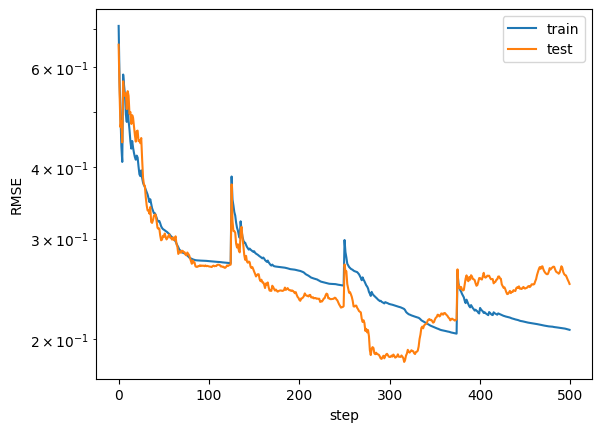

In [6]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

Text(0, 0.5, 'RMSE')

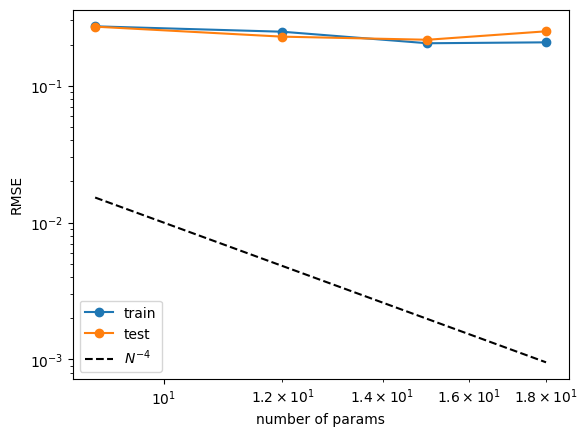

In [7]:
n_params = 3 * grids
train_vs_G = train_losses[(steps-1)::steps]
test_vs_G = test_losses[(steps-1)::steps]
plt.plot(n_params, train_vs_G, marker="o")
plt.plot(n_params, test_vs_G, marker="o")
plt.plot(n_params, 100*n_params**(-4.), ls="--", color="black")
plt.xscale('log')
plt.yscale('log')
plt.legend(['train', 'test', r'$N^{-4}$'])
plt.xlabel('number of params')
plt.ylabel('RMSE')

In [8]:
f_pred = model(dataset['test_input'])

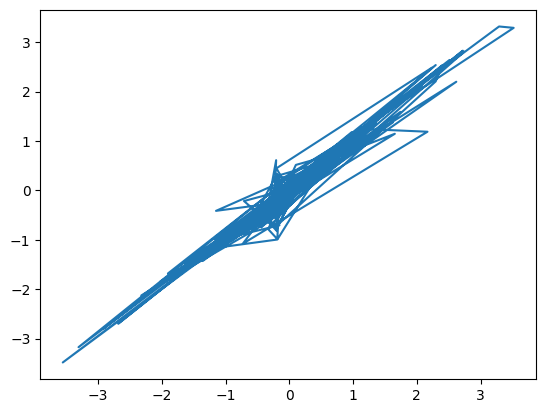

In [9]:
plt.plot(dataset['test_label'].detach().numpy(), f_pred.detach().numpy())

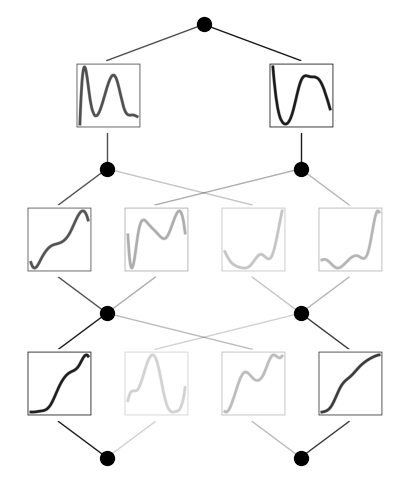

In [10]:
model.plot()

In [11]:
model.save_ckpt('Peaks_H2')

save this model to ./model_ckpt/Peaks_H2


In [12]:
data = get_model_data(model, dataset)
export_to_json(data,'Peaks_H2.json')

x range: [-1.78 , 1.74 ]
y range: [-1.64 , 3.25 ]
x range: [-1.69 , 1.79 ]
y range: [-0.67 , 0.61 ]
x range: [-1.78 , 1.74 ]
y range: [-0.40 , 0.13 ]
x range: [-1.69 , 1.79 ]
y range: [-1.11 , 2.06 ]
x range: [-2.32 , 3.83 ]
y range: [-1.26 , 4.39 ]
x range: [-1.34 , 2.35 ]
y range: [-0.58 , 1.80 ]
x range: [-2.32 , 3.83 ]
y range: [-0.71 , 1.40 ]
x range: [-1.34 , 2.35 ]
y range: [-0.58 , 1.56 ]
x range: [-3.37 , 2.80 ]
y range: [-4.34 , 1.93 ]
x range: [-1.77 , 2.00 ]
y range: [-2.47 , 3.82 ]
